In [1]:
'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
SD = cd - datetime.timedelta(days=35)
ED = cd + datetime.timedelta(days=365)

In [4]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

# Load in Observations
# ds_51 = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
# ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)
# ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

In [5]:
# Combine extent obs using highest quality first
ds_obs = ds_ext #.Extent.combine_first(da_79).combine_first(da_51).combine_first(da_81)

In [6]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [7]:
cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])

gfdlsipn
Aggregating...
Plotting...
0.016488918103277683  seconds.
piomas
yopp
Aggregating...
Plotting...


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


28.88232845114544  seconds.
bom
Aggregating...
Plotting...
1.2035662240814418  seconds.
cma
Aggregating...
Plotting...
5.209930457174778  seconds.
ecmwf
Aggregating...
Plotting...
1.076837579952553  seconds.
hcmr
Aggregating...
Plotting...
0.7318187081255019  seconds.
isaccnr
Aggregating...
Plotting...
0.3742250450886786  seconds.
jma
Aggregating...
Plotting...
0.3623673899564892  seconds.
metreofr
Aggregating...
Plotting...
0.3637628750875592  seconds.
ukmo
Aggregating...
Plotting...
4.344405783107504  seconds.
eccc
Aggregating...
Plotting...
0.7223898419179022  seconds.
kma
Aggregating...
Plotting...
4.0665652439929545  seconds.
ncep
Aggregating...
Plotting...
3.1421260291244835  seconds.
ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 52
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 56
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 62
  (nparts / max_parts))


Aggregating...
Plotting...
209.13371659792028  seconds.
ecmwfsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 25
  (nparts / max_parts))


Aggregating...
Plotting...
243.79527834407054  seconds.
Plotting observatoins


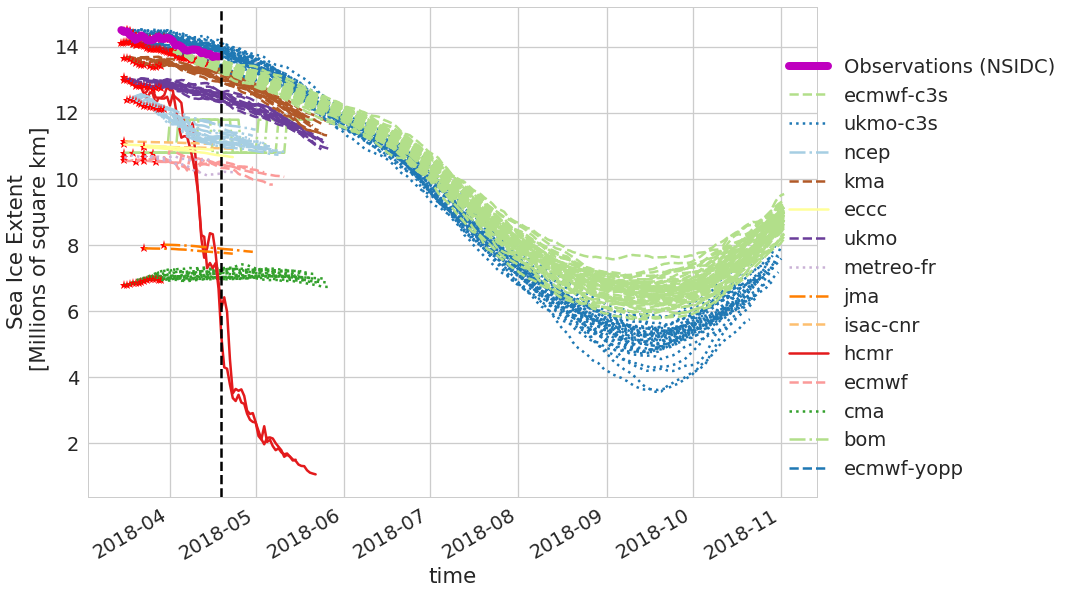

In [8]:
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # New Plot
    f = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(1, 1, 1) # Observations

    for (i, cmod) in enumerate(E.model.keys()):
#     for (i, cmod) in enumerate(['ukmetofficesipn']):
        print(cmod)

        # Load in Model
        model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            #print("Skipping model", cmod, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast, 
                                     chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
#         print(ds_model)
        
        # Select var of interest (if available)
        if cvar in ds_model.variables:
            ds_model = ds_model[cvar]
        else:
            continue
        
        # Select init of interest
        ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
        
        # Select last init
#         ds_model = ds_model.sel(init_time=ds_model.init_time.values[-1]).expand_dims('init_time')
#         print('only plotting last one inits')

#         Reduce to extent or area
        if metric1 == 'extent':
#             ds_model = ((ds_model >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
            ds_model = esio.calc_extent(ds_model, ds_region)
        else:
            raise ValueError('Not implemented')
            
        # Get color
        cc = next(cmap_c) 

        # Plot Model
        print('Plotting...')
#         print(ds_model)
        if i == 1: # Control only one initiailzation label in legend
            no_init_label = False
        else:
            no_init_label = True
        import timeit
        start_time = timeit.default_timer()
        #ds_model.load()
#         print(ds_model)
        esio.plot_reforecast(ds=ds_model, axin=ax1, 
                             labelin=E.model[cmod]['model_label'],
                             color=cc, marker=None,
                             linestyle=next(linecycler),
                             no_init_label=no_init_label)
        print( (timeit.default_timer() - start_time), ' seconds.' )
        
        # Memeory clean up
        ds_model = None
        
    # Plot observations
    print('Plotting observatoins')
    ds_obs.Extent.where(ds_obs.time>=np.datetime64(SD)).plot(ax=ax1, label='Observations (NSIDC)', color='m', linewidth=8)
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    cylims = ax1.get_ylim()
    
    # Plot current date line
    ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
    
    # Add legend (static)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))
    
    f.autofmt_xdate()
    ax1.set_ylim(cylims)
    plt.subplots_adjust(right=.8)
        
    # Save to file
    f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'.png')
    f.savefig(f_out,bbox_inches='tight',dpi=200)
    mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'.html'))


In [9]:
# Testing memory usage

# i=0
# cmod ='ukmetofficesipn'

# # Load in Model
# model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

# # Check we have files 
# files = glob.glob(model_forecast)

# ds_model = xr.open_mfdataset(model_forecast, chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
# ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
# ds_model



# cvar = 'sic'
# ds_model = ds_model[cvar]

# f = plt.figure(figsize=(15,10))
# ax1 = plt.subplot(1, 1, 1) # Observations
# esio.plot_reforecast(ds=ds_model, ds_region=ds_region,
#                      axin=ax1, 
#                      labelin=E.model[cmod]['model_label'],
#                      color='r', marker=None,
#                      linestyle=next(linecycler),
#                      no_init_label=False)